In [1]:
import os
import sys
import pandas as pd 

project_root = os.path.abspath(os.path.join(os.getcwd() , '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

load_cord = f"{project_root}/data/coordinates/ger_vs_sp_coordinates.csv"

cords_file = pd.read_csv(load_cord) 

In [2]:
import numpy as np

duplicates_df = cords_file[cords_file['frame'].duplicated(keep=False)]
duplicate_list = []

for i in range(len(duplicates_df) - 1):
    current_duplicate = duplicates_df['frame'].iloc[i]
    
    if current_duplicate in duplicate_list:
        next_row = duplicates_df.iloc[i + 1]
    else:
        duplicate_list.append(current_duplicate)

print(duplicate_list)

[np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(23), np.int64(24)]


In [3]:

for i in range(len(duplicate_list)):
    previous_value = duplicate_list[i] - 1 

    sum_dups = (cords_file['frame'] == duplicate_list[i]).sum()
    x_previous = cords_file.loc[cords_file['frame'] == previous_value, 'x'].values[0]
    y_previous = cords_file.loc[cords_file['frame'] == previous_value, 'y'].values[0]


    x_values = cords_file.loc[cords_file['frame'] == duplicate_list[i], 'x'].values
    y_values = cords_file.loc[cords_file['frame'] == duplicate_list[i], 'y'].values

    # Define the "previous" point (should already exist)
    previous = np.array([x_previous, y_previous])

    # Build list of all current coordinates (any number)
    current_coords = [np.array([x, y]) for x, y in zip(x_values, y_values)]

    # Compute distances to previous
    distances = [np.linalg.norm(previous - coord) for coord in current_coords]

    # Find the closest one instead of the farthest
    closest_index = np.argmin(distances)
    closest = current_coords[closest_index]

    frame_val = duplicate_list[i]

    # Keep only the row where both x and y match 'closest' and frame is the same
    cords_file = cords_file[~(
        (cords_file['frame'] == frame_val) & 
        ~((cords_file['x'] == closest[0]) & (cords_file['y'] == closest[1]))
    )]


In [4]:

i = 0
while i < len(cords_file)-1:
    j = i + 1
    
    frame_value_i = cords_file.iloc[i]['frame']
    x_previous = cords_file.loc[cords_file['frame'] == frame_value_i, 'x'].values
    y_previous = cords_file.loc[cords_file['frame'] == frame_value_i, 'y'].values

    frame_value_j = cords_file.iloc[j]['frame']
    x_current = cords_file.loc[cords_file['frame'] == frame_value_j, 'x'].values
    y_current = cords_file.loc[cords_file['frame'] == frame_value_j, 'y'].values

    previous = np.array([x_previous, y_previous])
    current = np.array([x_current, y_current])


    distances = np.linalg.norm(previous - current)

    
    # Drop entries that are in a euklidian distance bigger than 50 in after less den 5 frames difference -> I randomly chose this
    if(abs(frame_value_i - frame_value_j) < 5 and distances > 50):
        cords_file = cords_file.drop(cords_file.index[j])
        cords_file = cords_file.reset_index(drop=True)
        print(f"Distance for frame {i}: {frame_value_i} and {j}: {frame_value_j} is {distances}")

    else:
        i += 1 


Distance for frame 13: 13 and 14: 14 is 376.19675703014775
Distance for frame 13: 13 and 14: 15 is 376.3787985527346


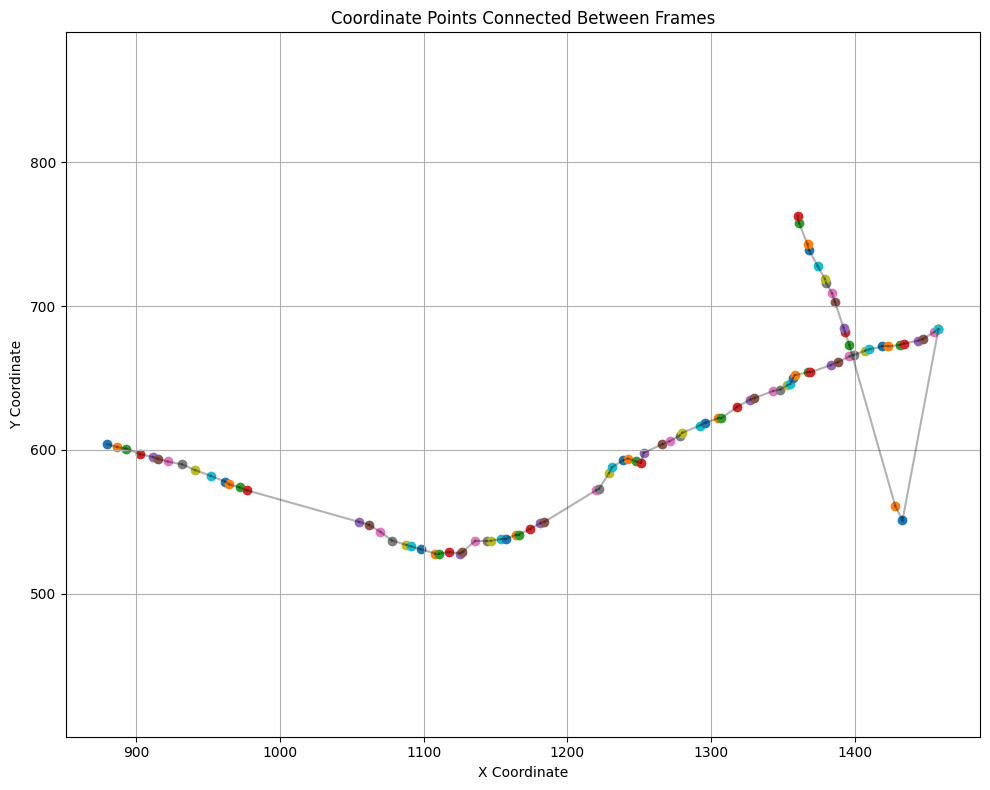

In [5]:
import matplotlib.pyplot as plt

cords_file = cords_file.sort_values(by='frame')

# Create a plot
plt.figure(figsize=(10, 8))

# Plot points for each frame and connect them
frame_numbers = cords_file['frame'].unique()

# Mirror Y coordinates across the x-axis without negative values
min_y = cords_file['y'].min()
max_y = cords_file['y'].max()
cords_file['y'] = max_y - (cords_file['y'] - min_y)

for i in range(len(frame_numbers) - 1):
    current_frame = frame_numbers[i]
    next_frame = frame_numbers[i + 1]
    
    # Get coordinates for current and next frame
    current_points = cords_file[cords_file['frame'] == current_frame]
    next_points = cords_file[cords_file['frame'] == next_frame]
    
    # Plot points for current frame
    plt.scatter(current_points['x'], current_points['y'], label=f'Frame {current_frame}')
    
    # Connect points between frames with lines
    for _, curr_point in current_points.iterrows():
        for _, next_point in next_points.iterrows():
            plt.plot([curr_point['x'], next_point['x']], 
                     [curr_point['y'], next_point['y']], 
                     'k-', alpha=0.3)  # Black lines with transparency

# Plot the last frame's points
last_frame = frame_numbers[-1]
last_points = cords_file[cords_file['frame'] == last_frame]
plt.scatter(last_points['x'], last_points['y'], label=f'Frame {last_frame}')

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Coordinate Points Connected Between Frames')
plt.grid(True)

# Equal aspect ratio ensures the coordinate system isn't distorted
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()